Calculation of meteor trajectory from head-echo dopplers
=======

Theory is adopted from Christian Steyaert et. al. 2010


In [ ]:
TMx = (x_M − x T )
TMy = (y M − y T )
TMz = (z M − z T )

In [8]:
import pylab
f = pylab.figure()

In [2]:
pylab.plot([1,2,3], [1,2,4], 'go-', label='line 1', linewidth=2)
pylab.plot([1,2,3], [1,2,2], 'bo-', label='line 1', linewidth=2)

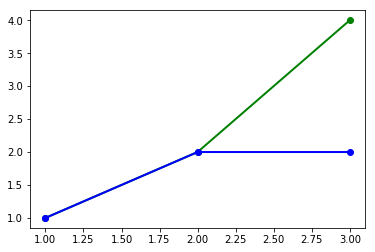

In [3]:
pylab.show()

Head Echo doppler function 
=======

The equation is  obtained from publication at http://adsabs.harvard.edu/abs/1998JIMO...26..117R (1998)

In [1]:
from sympy import symbols, sign, sqrt
from sympy.plotting import plot
t, f0, c, vm, r0 = symbols('t f_0 c v_m r_0')

In [2]:
delta_f = - sign(t) * sqrt(((2*f0)/c)**2 * (vm**2)/(r0**2/(vm**2 * t**2) + 1) )

In [3]:
delta_f.subs([(f0,55.260e6),(c,3e8),(vm,40e3),(r0,300e3), (t,1)])

-1947.56457926124

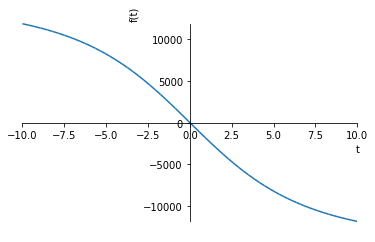

In [4]:
plot(delta_f.subs([(f0,55.260e6),(c,3e8),(vm,40e3),(r0,300e3)]), (t, -10, 10))

## Artificial meteor generator

In [26]:
%matplotlib inline

from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.constants
from scipy.optimize import minimize
from scipy.interpolate import interp1d, UnivariateSpline
from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

Generate Artificial meteor for algorithm testing

In [77]:
c = scipy.constants.c
f0 = 143050000
trans_station_point = np.array(geoC.GeographicToGeocentric(47.347993, 5.515079, 190))
t = 0.01

In [78]:
#Artificial meteors coordinates:

ZHR = 1

met_start_altitude = np.random.normal(100e3,20e3,ZHR)
met_stop_altitude = np.random.normal(60e3,20e3,ZHR)

met_start_lat = np.random.normal(49,1,ZHR)  
met_start_lon = np.random.normal(11,1,ZHR)

met_stop_lat = np.random.normal(49,1,ZHR) 
met_stop_lon = np.random.normal(11,1,ZHR)

met_velocity = np.random.normal(50000,20000,ZHR)
timesteps = np.arange(-10,10,t)

In [109]:
if True:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])

    met_start_lat = np.array([48.340593635025])
    met_start_lon = np.array([6.572188010297])

    met_stop_lat = np.array([49.52717828089])
    met_stop_lon = np.array([6.763558272451])

    met_velocity = np.random.normal(50000,20000,ZHR)
    met_velocity = np.array([24000])
    timesteps = np.arange(-10,10,t)

    
if False:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])

    met_start_lat = np.array([50.340593635025])
    met_start_lon = np.array([12.572188010297])

    met_stop_lat = np.array([48.52717828089])
    met_stop_lon = np.array([6.763558272451])

    met_velocity = np.random.normal(50000,20000,ZHR)
    met_velocity = np.array([35000])
    timesteps = np.arange(-15,15,t)

if False:#2017388
    multibolid_id = 2017388
    met_start_altitude = np.array([60000.0])
    met_stop_altitude = np.array([8910.7633450924])

    met_stop_lon = np.array([6.512636353428])
    met_stop_lat = np.array([51.944553218498])
    
    met_start_lon = np.array([9.996094184309])
    met_start_lat = np.array([51.230870109095])
    
    met_velocity = np.array([32000])
    
    
    
if True:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])

    met_start_lat = np.array([46])
    met_start_lon = np.array([10])

    met_stop_lat = np.array([50])
    met_stop_lon = np.array([8])

    met_velocity = np.array([35000])
    timesteps = np.arange(-10,10,t)
    
    
if True:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])
    
    met_start_lat = np.array([50])
    met_start_lon = np.array([8])

    met_stop_lat = np.array([46])
    met_stop_lon = np.array([10])
    
if True:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])

    met_start_lat = np.array([50])
    met_start_lon = np.array([5])

    met_stop_lat = np.array([51])
    met_stop_lon = np.array([16])

    met_velocity = np.array([35000])
    timesteps = np.arange(-10,10,t)
    
    
if True:
    met_start_altitude = np.array([80000.0])
    met_stop_altitude = np.array([45000.0])

    met_start_lat = np.array([51])
    met_start_lon = np.array([16])
    met_stop_lat = np.array([50])
    met_stop_lon = np.array([5])

    met_velocity = np.array([35000])
    timesteps = np.arange(-10,10,t)


    met_velocity = np.array([35000])
    timesteps = np.arange(-10,10,t)

In [110]:
def estimate_dopplers(trajectory, timesteps, f0, trans_station, rec_station):
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
    rec_to_met = np.empty([trajectory.shape[0], 1])
    trans_to_met = np.empty([trajectory.shape[0], 1])
    doppler = np.empty([trajectory.shape[0], 2])
    
    previous_rec_to_met = np.linalg.norm(rec_station - trajectory[0])
    previous_trans_to_met = np.linalg.norm(trans_station - trajectory[0])
    
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        rec_to_met[i] = np.linalg.norm(rec_station - trajectory[i])
        trans_to_met[i] = np.linalg.norm(trans_station - trajectory[i])
        
        #print(rec_to_met[i], trans_to_met[i])
    
        met_trans_speed = previous_trans_to_met - trans_to_met[i]
        previous_trans_to_met = trans_to_met[i]
        speed = met_trans_speed/t    
        f1 = ((c + speed)/c * f0)
        
        met_rec_speed = previous_rec_to_met - rec_to_met[i]    ## calculate bistatic velocity from known position
        previous_rec_to_met = rec_to_met[i]
        speed = met_rec_speed/t
        f2 = (c/(c - speed) * f1)
        doppler[i] = np.array([timesteps[i], f2-f0])
    return doppler

In [111]:
def estimate_dopplers2(trajectory, timesteps, f0, trans_station, rec_station):
    # alternative algorithm
    '''
        Returns array of dopplers for given transmitter to receiver position and defined frequency and known trajectory.
    '''
   
    doppler = np.empty([trajectory.shape[0], 2])
    t = timesteps[1] - timesteps[0]
    
    for i in range(trajectory.shape[0]):
        try: 
            # angle transmitter - meteor - reciever
            ba = trans_station-trajectory[i]
            bc = rec_station-trajectory[i]
            TMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))

            # angle trajectory - meteor - reciever
            ba = trajectory[i+1]-trajectory[i]
            bc = rec_station-trajectory[i]
            VMR = np.arccos(np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc)))

            # angle trajectory - meteor - axis (of angle transmitter-meter-reciever)
            VMA = VMR-TMR/2
            # radial speed of meteor to axis of TMR angle (Transmitter - meteor - reciever)
            radial_speed = np.cos(VMA)*(np.linalg.norm(trajectory[i]-trajectory[i+1])/t)
            doppler_offset = (radial_speed/c)*f0
            
        except Exception:
            pass
        
        doppler[i] = np.array([timesteps[i], doppler_offset])
    return doppler

Define Bolidozor network station. List may be updated from space.astro.cz server according to stored data.

In [112]:
stations = []
#stations.append({'name': 'Zebrak','latitude':49.8736, 'longitude':13.8986,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'uFlu','latitude':50.0795, 'longitude':14.4891,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'OBSUPICE','latitude':50.5067,'longitude':16.0115,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'SVAKOV','latitude':49.2607,'longitude':14.6917,'elevation':400, 'status': 'operational', 'type': 'receiver'})
stations.append({'name': 'ZVPP','latitude':48.9869,'longitude':14.4675,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'BPB','latitude':48.653153,'longitude':17.537413,'elevation':400, 'status': 'testing', 'type': 'receiver'})
#stations.append({'name': 'HPHK','latitude':50.1772,'longitude':15.8386,'elevation':400, 'status': 'testing', 'type': 'receiver'})
#stations.append({'name': 'OBSJAROMER','latitude':50.351397,'longitude':15.915878,'elevation':400, 'status': 'testing', 'type': 'receiver'})
stations.append({'name': 'JHRADEC','latitude':49.1314,'longitude': 14.9999,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'VALMEZ','latitude':49.463038,'longitude': 17.973544,'elevation':400, 'status': 'testing', 'type': 'receiver'})
#stations.append({'name': 'NACHODSKO','latitude':50.409407,'longitude':15.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM1','latitude':50.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'GERM2','latitude':50.009407,'longitude':9.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})
#stations.append({'name': 'IT1','latitude':45.409407,'longitude':10.414812,'elevation':400, 'status': 'operational', 'type': 'receiver'})

stations.append({'name': 'TREBIC','latitude':49.2071,'longitude':15.8759,'elevation':480, 'status': 'operational', 'type': 'receiver'})


In [113]:
# compute dopplers for multiple stations


from Geocentric import Geocentric
geoC = Geocentric(6378137, 6356752.314)

%matplotlib
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_title('Meteor Dopplers at multiple Bolidozor stations')
ax1.set_ylabel('Doppler [Hz]')
ax1.set_xlabel('Time [s]')
ax1.grid(True)

meteor_dopplers = [1,2]
met_points = np.empty([timesteps.size, 3])

for meteor in range(ZHR):
    
    # get meteor vector from start and stop point
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
    met_vect = met_start_point - met_stop_point
    print("vector", met_start_point, met_stop_point, met_vect)

    for i in range(timesteps.size):  # generate points on artifitial meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect/np.linalg.norm(met_vect) * (timesteps[i] * met_velocity[meteor]))
    
    for station in stations:
        rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
        
        doppler = estimate_dopplers(met_points, timesteps, f0, trans_station_point, rec_station_point)
        doppler2 = estimate_dopplers2(met_points, timesteps, f0, trans_station_point, rec_station_point)
             
        meteor_dopplers[meteor] = doppler
        #dopp_freq = np.vectorize(lambda x: (x+13250.0))

        plt.plot(doppler[1:,0], doppler[1:,1], label=station['name'] if meteor == 0 else "")
        plt.plot(doppler2[1:,0], doppler2[1:,1], '--', label=station['name']+" alg2" if meteor == 0 else "")
    
    plt.legend(loc=1)
    plt.xlabel("Relative time [s]")
    plt.ylabel("Doppler shift [Hz]")


Using matplotlib backend: TkAgg
vector [ 3914619.34236496  1122499.03342533  4995716.29687602] [ 4121047.80062862   360544.96440345  4897261.03738143] [-206428.45826367  761954.06902188   98455.25949459]


Plot artifitial meteor trajectory points

In [114]:
len(stations)

5

In [120]:

from mpltools import style
from mpltools import layout
import matplotlib.pyplot as plt


style.use('ggplot')

from mpl_toolkits.basemap import Basemap

land_color = 'lightgray'
water_color = 'lightblue'

fig, ax = plt.subplots(figsize=(20,20))
map = Basemap(projection='merc', llcrnrlat=45, urcrnrlat=55,
            llcrnrlon=5, urcrnrlon=25, resolution='i',area_thresh = 50)

land_color = 'lightgray'
water_color = 'lightblue'

map.fillcontinents(color=land_color, lake_color=water_color)
map.drawcoastlines()
map.drawcountries()
#map.drawparallels(np.arange(-90.,120.,30.))
#map.drawmeridians(np.arange(0.,420.,60.))
map.drawmapboundary(fill_color=water_color)
ax.set_title('Bolidozor network')

#x, y = map(np.array(near_transmitters.longitude_deg), np.array(near_transmitters.latitude_deg))
#map.plot(x, y, marker='o', markersize=6, markerfacecolor='red', linewidth=0)

colors = plt.get_cmap('jet')(np.linspace(0, 1.0, len(stations)))
ax.set_color_cycle(colors)
for station in stations:
    station_latitude = station['latitude']
    station_longitude = station['longitude']
    x, y = map(station_longitude, station_latitude)
    
    map.plot(x, y, marker='o', markersize=8, linewidth=0, label=station['name'])
plt.legend(numpoints=1,loc='best')

map.drawgreatcircle(met_start_lon, met_start_lat, met_stop_lon, met_stop_lat,linewidth=2,color='green')

map.ax = ax


/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [39]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2])
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])


Using matplotlib backend: TkAgg


Compute difference between of estimated trajectory dopplers and "real" simulated trajectory.

In [40]:
"""
Make virtual artificial meteor report from a model trajectory. 

"""

meteor_data = doppler[1:,0]

doppler_min = -500.0
doppler_max = 500.0

for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    dopplers = estimate_dopplers(met_points, timesteps, f0, trans_station_point, rec_station_point)
    indexes = np.where(np.logical_and(dopplers[1:,1] > doppler_min, dopplers[1:,1] < doppler_max ))
    station['doppler'] = np.concatenate((np.take(dopplers[1:,0], indexes), np.take(dopplers[1:,1], indexes)), axis = 0).T
#    met_doppler_function = interp1d(station['doppler'][:,1], station['doppler'][:,0]) # make interpolation function of measured dopplers. 
#    station['PCA_time'] = float(met_doppler_function(0)) # Get point of the closest approach time
    

In [41]:
outfile = "station_data" 
np.savez(outfile, timesteps=timesteps, stations=stations)

In [42]:
%matplotlib
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_title('Errors of estimated trajectory doppler time over all Bolidozor stations data')
ax1.set_ylabel('Time error [s]')
ax1.set_xlabel('Number of records')

meteor_dopplers = [1,2]

met_points = np.empty([timesteps.size, 3])


for meteor in range(ZHR):
    
    # get meteor vector from start and stop point
    met_start_point = np.array(geoC.GeographicToGeocentric(met_start_lat[meteor], met_start_lon[meteor], met_start_altitude[meteor]))
    met_stop_point = np.array(geoC.GeographicToGeocentric(met_stop_lat[meteor], met_stop_lon[meteor], met_stop_altitude[meteor]))
    met_vect = met_start_point - met_stop_point
    met_speed_vect = met_vect/np.linalg.norm(met_vect) * met_velocity[meteor]
    
    for i in range(timesteps.size):  # generate points on meteor trajectory (discretize in space)
        met_points[i] =  met_start_point + (met_vect * timesteps[i])
    
    doppler_deviations = error_func(make_meteor(), timesteps, stations)
    
    for station in doppler_deviations:
        plt.plot(doppler_deviations[station][:] , label=station if meteor == 0 else "")
    plt.legend(loc=1)

Using matplotlib backend: TkAgg


NameError: name 'error_func' is not defined

## Meteor parameters Estimator

In [43]:
def make_meteor():
    ## initial meteor trajectory guess 
    est_start_altitude = np.random.normal(100e3,20e3,1)
    est_stop_altitude = np.random.normal(60e3,20e3,1)
    
    est_start_lat = np.random.normal(49,2,1)  
    est_start_lon = np.random.normal(11,2,1)
    
    est_stop_lat = np.random.normal(49,2,1) 
    est_stop_lon = np.random.normal(11,2,1)
    
    est_velocity = np.random.normal(50000,20000,1)

    est_start_point = np.array(geoC.GeographicToGeocentric(est_start_lat, est_start_lon, est_start_altitude))
    est_stop_point = np.array(geoC.GeographicToGeocentric(est_stop_lat, est_stop_lon, est_stop_altitude))
    est_vect = est_start_point - est_stop_point
    est_speed_vect = est_vect/np.linalg.norm(est_vect) * est_velocity
    est_params = np.concatenate((est_start_point.ravel(), est_speed_vect.ravel()), axis=1)
    return est_params


In [44]:
def error_func(est_params, timesteps, stations):
    """
    Returns time difference between real and estimated meteor trajectory dopplers
    """
    from Geocentric import Geocentric
    geoC = Geocentric(6378137, 6356752.314)
    
    est_start_point = est_params[0:3]
    est_vect = est_params[3:6]
    est_points = np.empty([timesteps.size, 3])
    
    for i in range(timesteps.size):  # generate points of estimated meteor trajectory
        est_points[i] =  est_start_point + (est_vect * timesteps[i])

    doppler_deviations = {}
    for station in stations:
        doppler_deviation = np.zeros(station['doppler'].shape[0])
        rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
        est_doppler = estimate_dopplers(est_points, timesteps, f0, trans_station_point, rec_station_point)
        est_doppler_function = UnivariateSpline(est_doppler[1:,1], est_doppler[1:,0]) # make interpolation function of estimated dopplers. 

        for i in range(station['doppler'].shape[0]):  
            doppler_deviation[i] = (station['doppler'][:,0][i] - est_doppler_function(station['doppler'][:,1][i]))**2
        
        doppler_deviations[station['name']] = doppler_deviation
        
    return doppler_deviations


In [45]:
def station_errors(met_params, timesteps, stations):
    """
    Calculate total error value of estimated meteor params to every station signal. 
    """    
    doppler_errors = error_func(met_params, timesteps, stations)
    total_deviation = []
    for station in doppler_errors:
        total_deviation.append(np.sum(doppler_errors[station]))
    return total_deviation

### Gradient method of trajectory search

In [46]:
def total_error(est_params, timesteps, stations_data):
    return np.sum(station_errors(est_params, timesteps, stations)[5]) ## test to match meteor to one station
#    return station_errors(est_params, timesteps, stations)

In [47]:
def find_trajectory(timesteps,stations_data):
    ## initial meteor trajectory guess 

    est_params = make_meteor()
    res = minimize(total_error, est_params, args = (timesteps, stations_data,), method = 'Nelder-Mead', options = {'disp': True, 'maxfev': 1e10, 'maxiter': 1e10, 'ftol': 1e-6})
    return res

In [176]:
res = find_trajectory(timesteps, stations)

AxisError: axis 1 is out of bounds for array of dimension 1

In [177]:
out3 = res

NameError: name 'res' is not defined

In [178]:
out3

NameError: name 'out3' is not defined

In [179]:
out2

NameError: name 'out2' is not defined

In [180]:
out1

NameError: name 'out1' is not defined

In [181]:
est_params = out3['x']

NameError: name 'out3' is not defined

In [182]:
est_params

NameError: name 'est_params' is not defined

## Precision Analysis

In [183]:
est_start_point = est_params[0:3]
est_vect = est_params[3:6]
est_points = np.empty([timesteps.size, 3])

for i in range(timesteps.size):  # generate points on meteor trajectory (discretize in space)
    est_points[i] =  est_start_point + (est_vect * timesteps[i])

NameError: name 'est_params' is not defined

In [184]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_title('Meteor Trajectories')
ax.set_ylabel('Position [m]')
ax.set_xlabel('Position [m]')
ax.set_zlabel('Position [m]')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2], color = 'b', label= "Real")
ax.scatter(est_points[:,0], est_points[:,1], est_points[:,2], color = 'r', label= "Estimated")
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])


Using matplotlib backend: TkAgg


NameError: name 'est_points' is not defined

In [185]:
%matplotlib
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(met_points[:,0], met_points[:,1], met_points[:,2])
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))
    ax.scatter(rec_station_point[0], rec_station_point[1], rec_station_point[2])

Using matplotlib backend: TkAgg


In [186]:
%matplotlib
fig, ax1 = plt.subplots(figsize=(9, 7))
ax1.set_title('Dopplers of estimated  meteor trajectory')
ax1.set_ylabel('Doppler [Hz]')
ax1.set_xlabel('Time [s]')

    
for station in stations:
    rec_station_point = np.array(geoC.GeographicToGeocentric(station['latitude'], station['longitude'], station['elevation']))

    #doppler_met = estimate_dopplers(met_points, f0, trans_station_point, rec_station_point)
    doppler_est = estimate_dopplers(est_points, timesteps, f0, trans_station_point, rec_station_point)

#    plt.plot(station['doppler'][:,0], station['doppler'][:,1], label=station['name'] if meteor == 0 else "", color = 'b')
    plt.plot(station['doppler'][:,0], station['doppler'][:,1], label=station['name'] if meteor == 0 else "")
    plt.plot(doppler_est[1:,0], doppler_est[1:,1], color = 'r')
    
plt.legend(loc=1)

Using matplotlib backend: TkAgg


NameError: name 'est_points' is not defined

In [187]:
data_file = np.load("station_data.npz")
timesteps = data_file['timesteps']
stations = data_file['stations']

In [188]:
print hof

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-188-ff2a0489729d>, line 1)

In [189]:
print hof

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-189-ff2a0489729d>, line 1)

In [190]:
est_params = np.array(hof[0])

NameError: name 'hof' is not defined

In [191]:
est_params

NameError: name 'est_params' is not defined

In [192]:
est_params = array('d', [4054680.0680794725, 1080843.3217390168, 4911049.2573404275, -4949.93417629765, 41461.15462661179, -6000.00731814691])

TypeError: data type not understood

In [193]:
np.sum(station_errors(est_params, timesteps, stations))

NameError: name 'est_params' is not defined

In [194]:
station_errors(est_params, timesteps, stations)

NameError: name 'est_params' is not defined

In [195]:
est_params = np.load("estimated_parameters.npy")


Edmond záznamy

In [ ]:
http://meteor1.astrozor.cz:5252/multibolid/event/950404/
http://meteor1.astrozor.cz:5252/multibolid/event/1651523/
http://meteor1.astrozor.cz:5252/multibolid/event/1650562/
http://meteor1.astrozor.cz:5252/multibolid/event/1740199/
